In [1]:
#1. 패키지 임포트
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#2. GPU 사용 체크
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [3]:
# 3. mnist 데이터 다운로드
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 126154827.92it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111851979.52it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 40908636.71it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21027073.70it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
#4. 네트워크 정의
#class를 생성해서 네트워크 만들기
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        #기본 자료구조
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #class 함수
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [5]:
#5. 모델 불러오기
model = Net()
if is_cuda:
    model.cuda()

In [6]:
#모델 구성 확인
model

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [7]:
#6. 최적화 함수
optimizer = optim.SGD(model.parameters(),lr=0.01)#여기도 SGD

In [8]:
#7. 훈련 데이터 변수 준비
data , target = next(iter(train_loader))
#iter : 반복 가능한 객체에서 iterator
#next 현재 요소 다음 것을 차례로

In [9]:
data

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.424

In [10]:
target

tensor([6, 0, 0, 1, 6, 2, 8, 5, 3, 2, 5, 8, 0, 4, 4, 3, 7, 5, 6, 0, 5, 7, 1, 9,
        7, 0, 9, 5, 9, 5, 3, 5])

In [11]:
#8. 훈련 및 검증 함수
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        #훈련 할 때
        model.train()
    if phase == 'validation':
        #검증 할 때
        model.eval()
        volatile=True#검증 하면
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)#loss값

        #running_loss += F.nll_loss(output,target,size_average=False).data[0]
        running_loss += F.nll_loss(output,target,reduction='sum').item()#loss값을 계속 더함
        preds = output.data.max(dim=1,keepdim=True)[1] #??
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
          #훈련중 매개변수 최적화
            loss.backward() #역전파 이용
            optimizer.step() #역전파 단계에서 수집된 변화도로 매개변수를 조정

    loss = running_loss/len(data_loader.dataset) #loss값 평균
    accuracy = 100. * running_correct/len(data_loader.dataset) #정확도

    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [12]:
#9. 훈련
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.62 and training accuracy is 48211/60000     80.35
validation loss is  0.15 and validation accuracy is 9548/10000     95.48
training loss is   0.2 and training accuracy is 56576/60000     94.29
validation loss is 0.095 and validation accuracy is 9703/10000     97.03
training loss is  0.15 and training accuracy is 57369/60000     95.61
validation loss is 0.072 and validation accuracy is 9767/10000     97.67
training loss is  0.13 and training accuracy is 57782/60000      96.3
validation loss is  0.06 and validation accuracy is 9805/10000     98.05
training loss is  0.11 and training accuracy is 58007/60000     96.68
validation loss is 0.055 and validation accuracy is 9822/10000     98.22
training loss is   0.1 and training accuracy is 58130/60000     96.88
validation loss is 0.048 and validation accuracy is 9842/10000     98.42
training loss is 0.095 and training accuracy is 58321/60000      97.2
validation loss is 0.045 and validation accuracy is 9848/10000     98.48

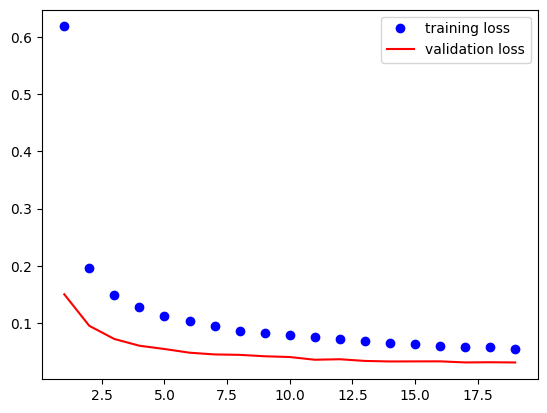

In [13]:
#10. 훈련 데이터와 검증 데이터의 손실 그래프
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

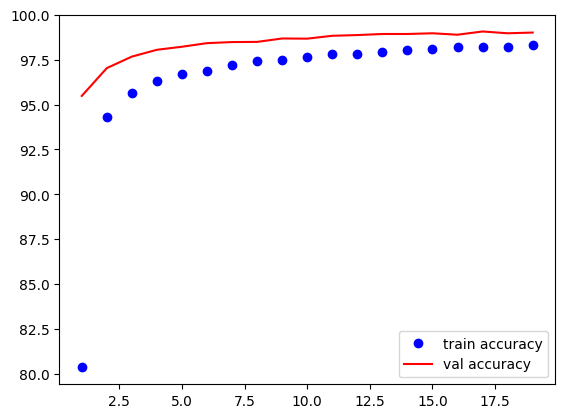

In [14]:
#11. 훈련 데이터와 검증 데이터의 정확도 그래프
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()